
I'm trying to get murders per 100,000 inhabitants per US state per race. I need this because I need two populations to compare. I have UNODC murder rates for the US as a whole, African–Americans as percentage of total population (1790–2010) by U.S. state, White American population as of 2000 and 2010 censuses, and a year common to each of these tables. How do I get the rate per race per state from that?

If you are curious about the choice of subject matter, I'm trying to disprove things with simple statistics - generally, Nazi pseudoscience about genetics and race and Marxist pseudoscience about the malleability of human nature. In this case, it's the idea that homicide rate correlates with the continent your ancestors evolved on. It's mostly a disappointing exercise trying to simplify something that is complex, but I'm merely trying to show that simple, ideologically-motivated ideas don't hold up. And these exercises that I am giving myself are good practice.

In [1]:

%pprint

Pretty printing has been turned OFF


In [3]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

from storage import Storage
from stats_scraping_utils import StatsScrapingUtilities

s = Storage()
ssu = StatsScrapingUtilities(s=s)
%who

StatsScrapingUtilities	 Storage	 s	 ssu	 sys	 



We are looking to compute the intentional homicide rate per 100,000 inhabitants for our max year.

In [13]:

# UNODC intentional homicide victims: intentional homicide victims per 100,000 inhabitants
if s.pickle_exists('country_murder_df'):
    country_murder_df = s.load_object('country_murder_df')
else:
    file_path = '../data/html/intentional_homicide_victims_per_100K_inhabitants.html'
    import os.path as osp
    if osp.exists(file_path):
        import pandas as pd
        tables_df_list = pd.read_html(file_path)
        print([(i, df.shape) for (i, df) in enumerate(tables_df_list) if df.shape[0] > 50])
        country_murder_df = tables_df_list[0]
        country_murder_df = country_murder_df.set_index('Country (or dependent territory, subnational area, etc.)')
    else:
        wikipedia_url = 'https://en.wikipedia.org/wiki/List_of_countries_by_intentional_homicide_rate'
        %run ../load_magic/soup.py
        tables_df_list = get_wiki_tables(wikipedia_url)
        country_murder_df = tables_df_list[1]
        country_murder_df = country_murder_df.iloc[1:].set_index('Location')
        country_murder_df.index = country_murder_df.index.map(lambda x: str(x).split('*')[0])
    country_murder_df.index.name = 'Country'
#     country_murder_df.columns = ['Region', 'Subregion', 'Rate', 'Count', 'Year', 'Source']
#     country_murder_df['Rate'] = country_murder_df['Rate'].map(lambda x: float(x))
country_murder_df#.head(5).T.head(5).T

[(1, (196, 7)), (2, (51, 2)), (3, (16, 2)), (0, (6, 3)), (4, (6, 2))]


,Region,Subregion,Rate,Count,Year,Source
Country,,,,,,
Afghanistan,Asia,Southern Asia,6.7,2474.0,2018.0,NSO
Albania,Europe,Southern Europe,2.1,61.0,2020.0,NSO
Algeria,Africa,Northern Africa,1.3,580.0,2020.0,CTS
Andorra,Europe,Southern Europe,2.6,2.0,2020.0,CTS
Angola,Africa,Middle Africa,4.8,1217.0,2012.0,NSO
...,...,...,...,...,...,...
Venezuela,Americas,South America,36.7,10598.0,2018.0,CTS
Vietnam,Asia,South-Eastern Asia,1.5,1358.0,2011.0,WHO
Yemen,Asia,Western Asia,6.8,1703.0,2013.0,NSO


In [15]:

# UNODC intentional homicide victims: intentional homicide victims per 100,000 inhabitants
if s.pickle_exists('us_murder_df'):
    us_murder_df = s.load_object('us_murder_df')
else:
    wikipedia_url = 'https://www.mdch.state.mi.us/osr/deaths/Homicdx.asp'
    %run ../load_magic/soup.py
    tables_df_list = get_wiki_tables(wikipedia_url)
    us_murder_df = tables_df_list[0]
    columns_list = []
    for column_tuple in us_murder_df.iloc[45:47].T.to_dict()[45].keys():
        prefix = column_tuple[1].replace(' ', '_')
        suffix = column_tuple[2].replace(' ', '_')
        if (prefix == suffix): columns_list.append(prefix)
        else: columns_list.append(prefix + '_' + suffix)
    us_murder_df.columns = columns_list
    us_murder_df = us_murder_df.iloc[47:].apply(pd.to_numeric, errors='coerce').dropna(axis='index').set_index('Year')
    us_murder_df.index = us_murder_df.index.astype(int)
    s.store_objects(us_murder_df=us_murder_df)

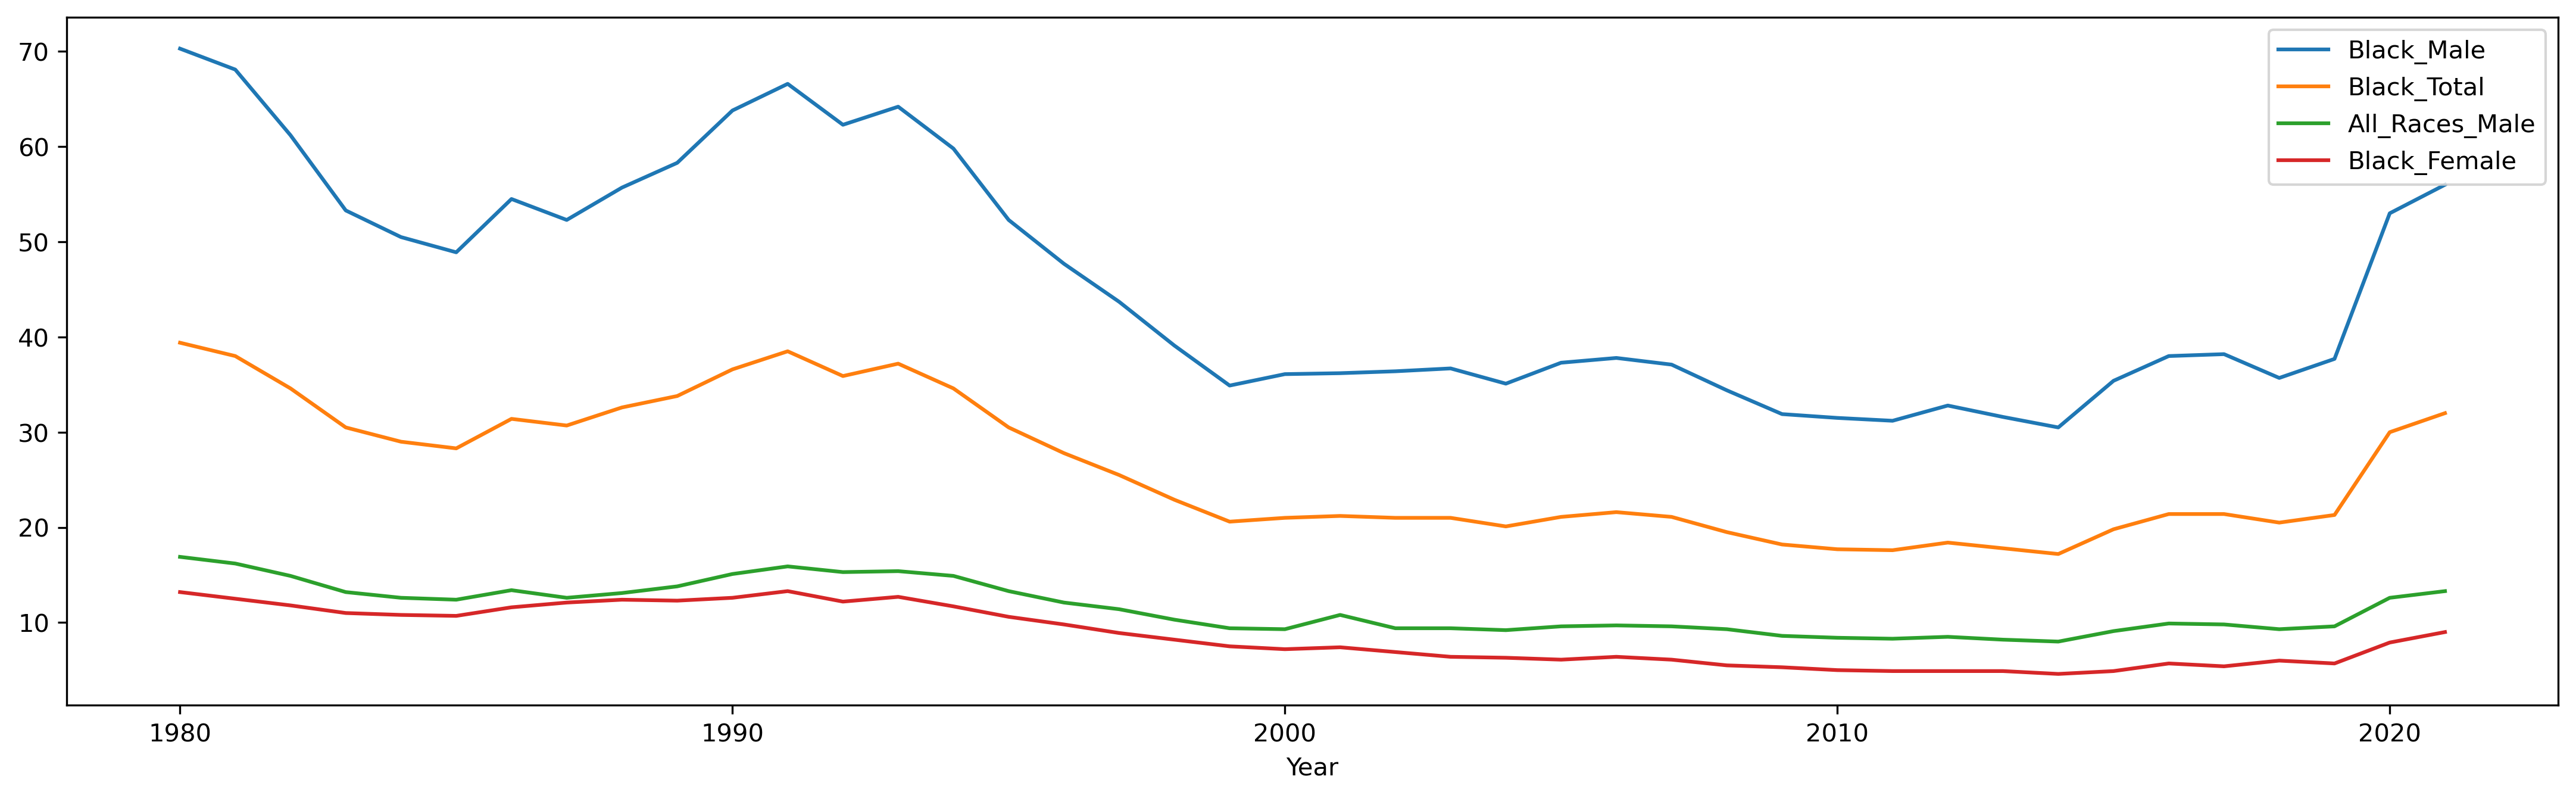

In [23]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(18, 5), dpi=300)
columns_list = us_murder_df.sum().sort_values(ascending=False).index.tolist()[:4]
us_murder_df[columns_list].plot(ax=ax);

In [12]:

# FBI Expanded Homicide Data Table 6 Murder
# Race, Sex, and Ethnicity of Victim by Race, Sex, and Ethnicity of Offender, 2019
if s.pickle_exists('us_perps_df'):
    us_perps_df = s.load_object('us_perps_df')
else:
    file_path = '../data/xlsx/expanded-homicide-data-table-6.xlsx'
    import os.path as osp
    if osp.exists(file_path):
        import pandas as pd
        us_perps_df = pd.read_excel(file_path)
        columns_list = []
        import re
        for column_dict in us_perps_df.iloc[3:5].T.fillna(method='ffill').T.fillna(method='ffill').to_dict().values():
            column_tuple = tuple(column_dict.values())
            prefix = re.sub(r'\s+', '_', column_tuple[0].strip())
            suffix = re.sub(r'\s+', '_', column_tuple[1].strip())
            if (prefix == suffix): columns_list.append(prefix)
            else: columns_list.append(prefix + '_' + suffix.replace('1', ''))
        us_perps_df.columns = columns_list
        us_perps_df = us_perps_df.iloc[5:9].set_index('Race_of_victim').apply(pd.to_numeric, errors='coerce').astype(int)
        us_perps_df.index = us_perps_df.index.map(lambda x: re.sub(r'\s+', '_', str(x).replace('1', '').strip()))
        s.store_objects(us_perps_df=us_perps_df)
us_perps_df.T

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\StatsByCountry\saves\pkl\us_perps_df.pkl


Race_of_victim,White,Black_or_African_American,Other_race,Unknown_race
Total,3299,2906,247,126
Race_of_offender_White,2594,246,57,51
Race_of_offender_Black_or_African_American,566,2574,40,38
Race_of_offender_Other,56,23,138,8
Race_of_offender_Unknown,83,63,12,29
Sex_of_offender_Male,2915,2606,211,107
Sex_of_offender_Female,359,273,34,17
Sex_of_offender_Unknown,25,27,2,2
Ethnicity_of_offender_Hispanic_or_Latino,738,95,18,23
Ethnicity_of_offender_Not_Hispanic_or_Latino,1542,1841,144,47


In [32]:

# Prove that the Total column is every sum of each demographic category
demographic_categories_list = ['Race', 'Sex', 'Ethnicity']
for dc in demographic_categories_list:
    print()
    print(dc)
    for idx in us_perps_df.index:
        total = 0
        columns_list = [cn for cn in us_perps_df.columns if cn.startswith(dc)]
        for cn in columns_list:
            total += us_perps_df.loc[idx, cn]
        print(idx, total, total==us_perps_df.loc[idx, 'Total'])


Race
White 3299 True
Black_or_African_American 2906 True
Other_race 247 True
Unknown_race 126 True

Sex
White 3299 True
Black_or_African_American 2906 True
Other_race 247 True
Unknown_race 126 True

Ethnicity
White 3299 True
Black_or_African_American 2906 True
Other_race 247 True
Unknown_race 126 True


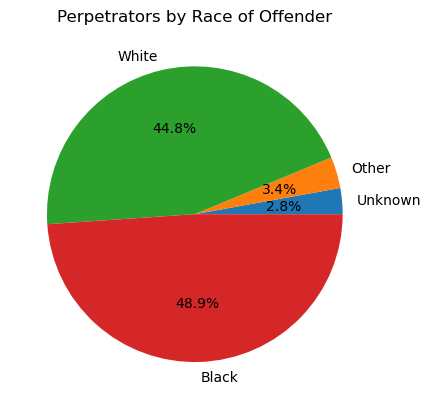

In [36]:

# Values for the pie chart
unknown_perps = us_perps_df.Race_of_offender_Unknown.sum()
other_perps = us_perps_df.Race_of_offender_Other.sum()
white_perps = us_perps_df.Race_of_offender_White.sum()
black_perps = us_perps_df.Race_of_offender_Black_or_African_American.sum()

# Labels for the pie chart
labels = ['Unknown', 'Other', 'White', 'Black']
sizes = [unknown_perps, other_perps, white_perps, black_perps]

# Plot the pie chart
import matplotlib.pyplot as plt
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Perpetrators by Race of Offender');

In [135]:

mask_series = (country_murder_df['Subregion'].isin(['Eastern Africa', 'Middle Africa',
                                                  'Southern Africa', 'Western Africa']))
african_homicide_rates_list = country_murder_df[mask_series]['Rate'].dropna().tolist()

In [136]:

mask_series = (country_murder_df['Region'] == 'Europe')
european_homicide_rates_list = country_murder_df[mask_series]['Rate'].dropna().tolist()

In [160]:

import numpy as np

pop_dict = us_pop_df['Population_{}'.format(max_year)].to_dict()

def f(row_series):
    state = row_series['State']
    count = row_series['Victim Count']
    if state in pop_dict:
        population = pop_dict[state]
        rate = (100000/population)*count
    else:
        rate = np.nan
    
    return rate

homicides_max_year_df['Rate'] = homicides_max_year_df.apply(f, axis='columns')
homicides_max_year_df.head(5)

,State,Race,Victim Count,Percent,Rate
0,Alabama,Black,20.0,0.262,0.418433
1,Alabama,Native American/Alaska Native,0.0,NaN,0.000000
2,Alabama,Unknown,0.0,NaN,0.000000
3,Alabama,White,0.0,0.685,0.000000
4,Alaska,Asian/Pacific Islander,6.0,NaN,0.844796


In [161]:

mask_series = (homicides_max_year_df['Race'] == 'Black')
black_homicide_rates_list = homicides_max_year_df[mask_series]['Rate'].dropna().tolist()

In [162]:

mask_series = (homicides_max_year_df['Race'] == 'White')
white_homicide_rates_list = homicides_max_year_df[mask_series]['Rate'].dropna().tolist()

In [163]:

mask_series = (homicides_max_year_df['Race'] == 'Black')
mean_black_homicide_rate = homicides_max_year_df[mask_series]['Rate'].mean()
mask_series = (homicides_max_year_df['Race'] == 'White')
mean_white_homicide_rate = homicides_max_year_df[mask_series]['Rate'].mean()
mask_series = (country_murder_df['Region'] == 'Europe')
mean_european_homicide_rate = country_murder_df[mask_series]['Rate'].mean()
mask_series = (country_murder_df['Subregion'].isin(['Eastern Africa', 'Middle Africa',
                                                  'Southern Africa', 'Western Africa']))
mean_african_homicide_rate = country_murder_df[mask_series]['Rate'].mean()
print_str = '''
Mean African Homicide Rate: {}
Mean Black Homicide Rate: {}
Mean European Homicide Rate: {}
Mean White Homicide Rate: {}'''
print(print_str.format(mean_african_homicide_rate, mean_black_homicide_rate,
                       mean_european_homicide_rate, mean_white_homicide_rate))


Mean African Homicide Rate: 8.23843137254902
Mean Black Homicide Rate: 0.2606705226302728
Mean European Homicide Rate: 1.5127450980392159
Mean White Homicide Rate: 0.2440347538773676


In [164]:

mask_series = (homicides_df['Perpetrator Race'] == 'Black') & (homicides_df['Year'] == max_year)
victim_count = homicides_df[mask_series]['Victim Count'].sum()
pop_count = us_pop_df['Population_{}'.format(max_year)].sum()
victim_count*100000/pop_count

0.11028499462881307

In [165]:

mask_series = (homicides_max_year_df['Race'] == 'Black')
homicides_max_year_df[mask_series]['Victim Count'].sum()

681.0

In [166]:

from scipy.stats import ttest_ind

format_str = 'Here are the country groups tested against the murder rate data you agreed to:'
print(format_str)
print()

hypothesis_format_str = 'We {} reject the null hypothesis that the {} '
hypothesis_format_str += 'population did not come from the same distribution as the {} population.'

def test_populations(global_data, us_data, country_str, test_race):
    t, p = ttest_ind(a=global_data, b=us_data, axis=0, equal_var=True, nan_policy='raise')
    print('{} vs {}: t={:0.2f}; p={:0.3f}'.format(country_str, test_race, t[0], p[0]))

    # If that probability is small we can reject the null hypothesis
    if p[0] < 0.05:
        can_cannot = 'can'
    else:
        can_cannot = 'cannot'
    print(hypothesis_format_str.format(can_cannot, test_race, country_str))
    print()

test_race = 'US White'
us_white_data = np.array(white_homicide_rates_list).reshape((-1, 1))
global_european_data = np.array(european_homicide_rates_list).reshape((-1, 1))
global_african_data = np.array(african_homicide_rates_list).reshape((-1, 1))

country_str = 'European countries'
test_populations(global_european_data, us_white_data, country_str, test_race)
country_str = 'African countries'
test_populations(global_african_data, us_white_data, country_str, test_race)

test_race = 'US Black'
us_black_data = np.array(black_homicide_rates_list).reshape((-1, 1))

country_str = 'European countries'
test_populations(global_european_data, us_black_data, country_str, test_race)
country_str = 'African countries'
test_populations(global_african_data, us_black_data, country_str, test_race)

Here are the country groups tested against the murder rate data you agreed to:

European countries vs US White: t=5.36; p=0.000
We can reject the null hypothesis that the US White population did not come from the same distribution as the European countries population.

African countries vs US White: t=7.38; p=0.000
We can reject the null hypothesis that the US White population did not come from the same distribution as the African countries population.

European countries vs US Black: t=4.87; p=0.000
We can reject the null hypothesis that the US Black population did not come from the same distribution as the European countries population.

African countries vs US Black: t=6.90; p=0.000
We can reject the null hypothesis that the US Black population did not come from the same distribution as the African countries population.



In [167]:

import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline

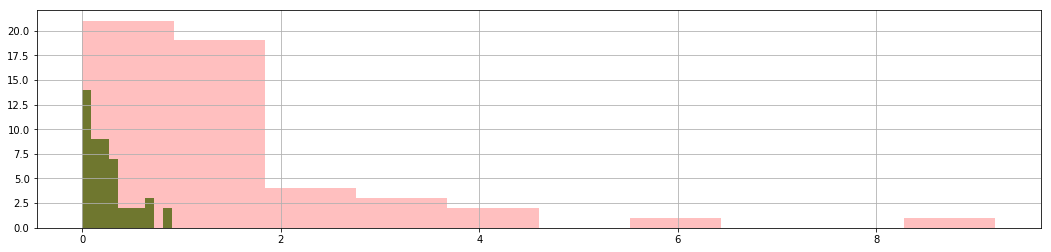

In [168]:

fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot(111, autoscale_on=True)
whites_AxesSubplot = pd.Series(white_homicide_rates_list).hist(ax=ax, bins=10, alpha=0.75, color='green')
europeans_AxesSubplot = pd.Series(european_homicide_rates_list).hist(ax=ax, bins=10, alpha=0.25,
                                                                     color='red')

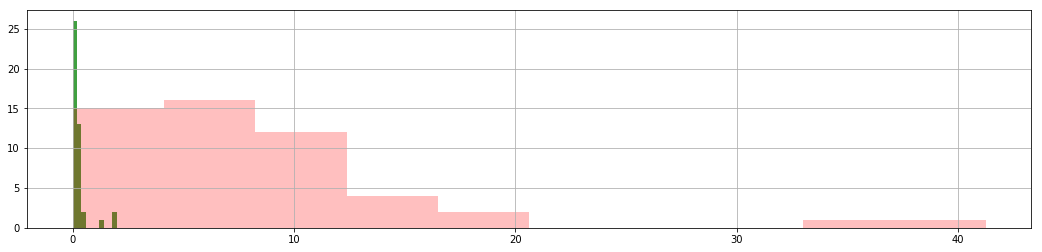

In [169]:

fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot(111, autoscale_on=True)
blacks_AxesSubplot = pd.Series(black_homicide_rates_list).hist(ax=ax, bins=10, alpha=0.75, color='green')
africans_AxesSubplot = pd.Series(african_homicide_rates_list).hist(ax=ax, bins=10, alpha=0.25,
                                                                   color='red')

In [172]:
%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = 'notebook_path = ' + "'" + attribs['data-notebook-path'].value + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [171]:
# %load ../../load_magic/nbviewer.py

from IPython.display import HTML

notebook_viewer_url = 'https://nbviewer.jupyter.org/github/dbabbitt/notebooks/blob/master/'
notebook_viewer_url += '/'.join(notebook_path.split('/')[1:])
html_str = 'Click <a href="{}" target="_blank">here</a> to view notebook in nbviewer.'
HTML(html_str.format(notebook_viewer_url))

NameError: name 'notebook_path' is not defined

In [2]:

dir(pd)

NameError: name 'pd' is not defined